# Solution 8.5.1 Vending Machines

Author: Marcel Steiner-Curtis \
Date: 21.08.2019 sml, 06.03.2021 sml: Python-Jupyter Notebook

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model as sm
from statsmodels.graphics.gofplots import ProbPlot

In [2]:
#   Function to reproduce the 4 base plots of an OLS model in R
#   -----------------------------------------------------------
#   Source: https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
#   Author: Robert Alvarez
#   Date: 04.06.2018
def graph(formula, x_range, label=None):
    """
    Helper function for plotting Cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.
    ---
    Inputs:
    X: A numpy array or pandas dataframe of the features to use in 
       building the linear regression model
    y: A numpy array or pandas series/dataframe of the target variable 
       of the linear regression model
    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. 
                          If not provided, will be generated from X, y
    """
    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()
    
    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    #-----------------------
    #   Tukey-Anscombe plot
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x=model_fitted_y, 
                                      y=dataframe.columns[-1], 
                                      data=dataframe, 
                                      lowess=True, 
                                      color='blue', 
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals');
    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i, xy=(model_fitted_y[i], model_residuals[i]));
    #----------------------
    #   Scale-location plot
    plot_lm_2 = plt.figure()
    plt.scatter(x=model_fitted_y, y=model_norm_residuals_abs_sqrt, color='blue');
    sns.regplot(x=model_fitted_y, 
                y=model_norm_residuals_abs_sqrt, 
                scatter=False,
                ci=False, 
                lowess=True, 
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_2.axes[0].set_title('Scale-Location')
    plot_lm_2.axes[0].set_xlabel('Fitted values')
    plot_lm_2.axes[0].set_ylabel('$\sqrt{|Standardized~~Residuals|}$');
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_2.axes[0].annotate(i, xy=(model_fitted_y[i], 
                                          model_norm_residuals_abs_sqrt[i]));
    #-----------
    #   q-q plot
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_3 = QQ.qqplot(line='45', markerfacecolor='b', markeredgecolor='b')
    plot_lm_3.axes[0].set_title('Normal Q-Q')
    plot_lm_3.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_3.axes[0].set_ylabel('Standardized Residuals');
    # annotations
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_3.axes[0].annotate(i, xy=(np.flip(QQ.theoretical_quantiles, 0)[r], 
                                          model_norm_residuals[i]));
    #------------------------
    #   Residuals vs Leverage
    plot_lm_4 = plt.figure();
    plt.scatter(x=model_leverage, y=model_norm_residuals, color='blue');
    sns.regplot(x=model_leverage, 
                y=model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i, xy=(model_leverage[i], 
                                          model_norm_residuals[i]));
    
    p = len(model_fit.params) # number of model parameters
    # 0.5 line
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
          np.linspace(0.001, 
                      max(model_leverage), 50), 'Cook\'s distance')
    # 1 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),  
          np.linspace(0.001, max(model_leverage), 50)) 
    plot_lm_4.legend(loc='upper right');


##   Solution 8.5.1 Vending Machines

read data

In [3]:
os.chdir('../04 Datasets')
data = pd.read_csv('vending-machines.dat', sep='\t')
data.head()

,Time,Volume,Distance,Town
0,16.68,7,560,San Diego
1,11.50,3,220,San Diego
2,12.03,3,340,San Diego
3,14.88,4,80,San Diego
4,13.75,6,150,San Diego


In [4]:
pltorig = plt.rcParams['figure.figsize']
pltorig

[6.4, 4.8]

# (a) Fit Model with Original Variables

Estimation of the parameters

In [5]:
mod = smf.ols(formula='Time ~ Volume', data=data).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Time   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     307.8
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           8.22e-15
Time:                        14:48:18   Log-Likelihood:                -70.197
No. Observations:                  25   AIC:                             144.4
Df Residuals:                      23   BIC:                             146.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3208      1.371      2.422      0.024       0.484       6.157
Volume         2.1762      0.124     17.546      0.000       1.920       2.433
==============================================================================
Omnibus:                        2.383   Durbin-Watson:                   0.946
Prob(Omnibus):                  0.304   Jarque-Bera (JB):                1.037
Skew:                           0.388   Prob(JB):                        0.595
Kurtosis:                       3.627   Cond. No.                         18.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

scatter diagram: Time versus Volume

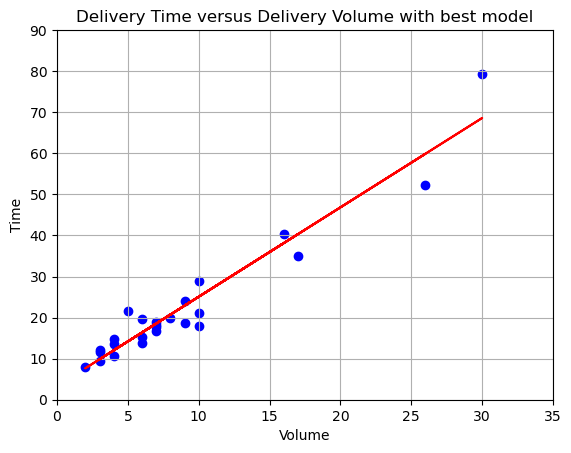

In [6]:
plt.close()
plt.xlim([0,35])
plt.ylim([0,90])
plt.scatter(data.Volume, data.Time, color='blue')
plt.grid()            
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.title('Delivery Time versus Delivery Volume with best model')
plt.xlabel('Volume')
plt.ylabel('Time')
#   add best model
plt.plot(data.Volume, mod.predict(), color='red')
plt.show()

residual analysis

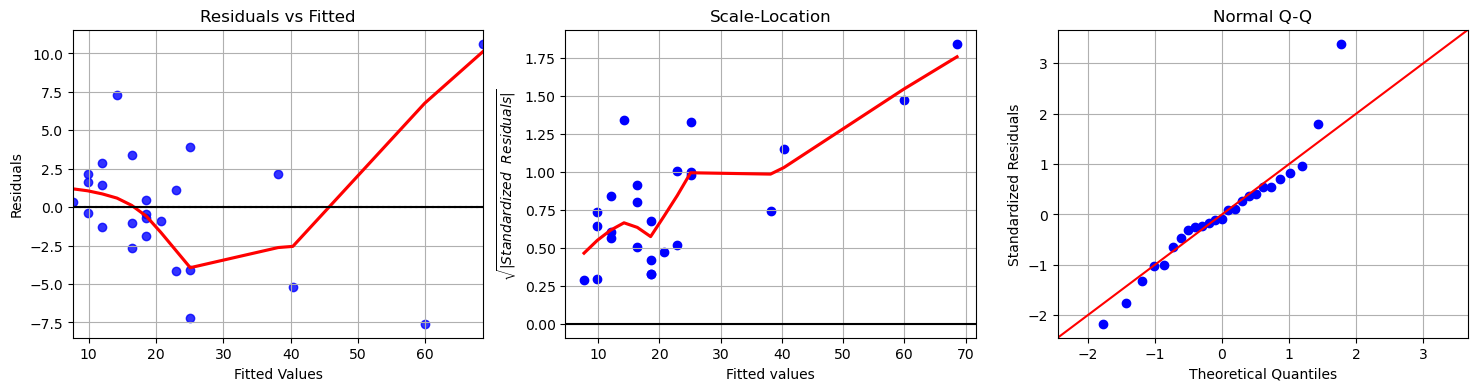

In [7]:
plt.close()
plt.rcParams['figure.figsize'] = [18, 4]
fig, axs = plt.subplots(1, 3)
#   Tukey-Anscombe plot
axs[0].grid()
sns.residplot(x=mod.fittedvalues, 
              y=mod.resid, data=data, 
              lowess=True, color='blue', line_kws={'color': 'red'}, ax=axs[0])
axs[0].axhline(y=0, color='black')
axs[0].set_title('Residuals vs Fitted')
axs[0].set_xlabel('Fitted Values')
axs[0].set_ylabel('Residuals')
#   scale-location plot
axs[1].grid() 
axs[1].scatter(x=mod.fittedvalues, 
               y=np.sqrt(np.abs(mod.get_influence().resid_studentized_internal)), 
               color='blue')
sns.regplot(x=mod.fittedvalues, 
            y=np.sqrt(np.abs(mod.get_influence().resid_studentized_internal)),
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red'}, 
            ax=axs[1])
axs[1].axhline(y=0, color='black')
axs[1].set_title('Scale-Location')
axs[1].set_xlabel('Fitted values')
axs[1].set_ylabel('$\sqrt{|Standardized~~Residuals|}$')
#   q-q plot
QQ = ProbPlot(mod.get_influence().resid_studentized_internal)
QQ.qqplot(line='45', markerfacecolor='b', markeredgecolor='b', ax=axs[2])
axs[2].set_title('Normal Q-Q')
axs[2].set_xlabel('Theoretical Quantiles')
axs[2].set_ylabel('Standardized Residuals')
axs[2].grid() 
plt.rcParams['figure.figsize'] = [6, 4]

short

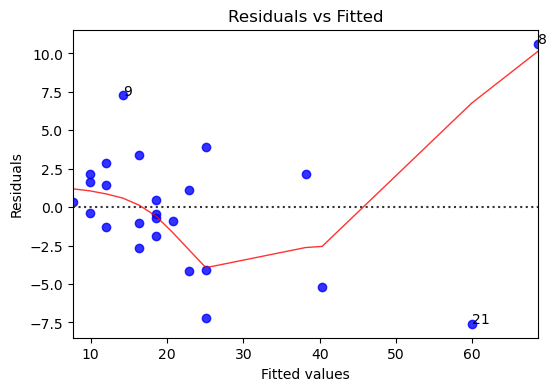

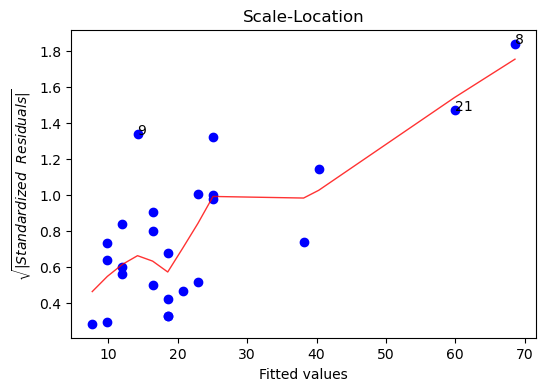

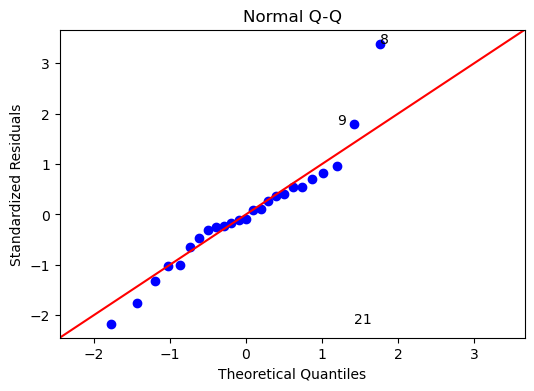

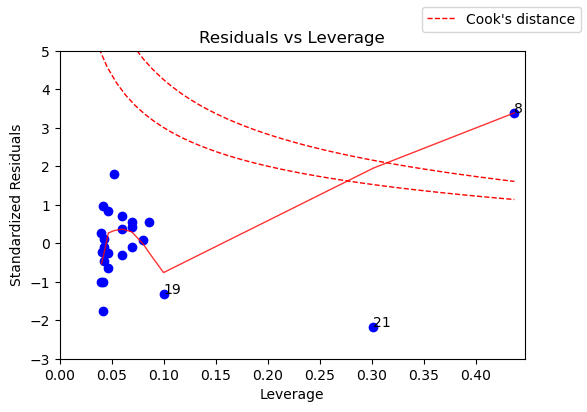

In [8]:
diagnostic_plots(X=data.Volume, y=data.Time, model_fit=mod)

REMARKS:
1.  Tukey-Anscombe plot shows outlier with index $i=9$ which affects smooth curve.
    In the simulation it is visible that the original curve is extreme.\
    => The expected value of the residuals cannot be constant.
2.  Scale-location plot shows a clear upwards trend.
    In the simulation it is visible that the original curve is extreme.\
    => The scattering of the residuals is not constant.
3.  q-q plot shows a slightly heavy tail and the outlier with index $i=9$ is again obvious.\
    => Residuals are not normally distributed.

CONCLUSION: The fit is not satisfactory. Try transformations of response and explanatory variable.

#   (b) Fit Model with Transformed Variables

In [9]:
data['Timelog']   = np.log10(data.Time)
data['Volumelog'] = np.log10(data.Volume)
data['Volumesq']  = np.sqrt(data.Volume)

# 1. Variant

In [10]:
mod1 = smf.ols(formula='Timelog ~ Volumelog', data=data).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Timelog   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     196.7
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           9.25e-13
Time:                        14:48:19   Log-Likelihood:                 30.169
No. Observations:                  25   AIC:                            -56.34
Df Residuals:                      23   BIC:                            -53.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6539      0.047     13.817      0.000       0.556       0.752
Volumelog      0.7457      0.053     14.026      0.000       0.636       0.856
==============================================================================
Omnibus:                        0.327   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.849   Jarque-Bera (JB):                0.333
Skew:                           0.232   Prob(JB):                        0.847
Kurtosis:                       2.678   Cond. No.                         6.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

scatter diagram: log(Time) versus log(Volume)

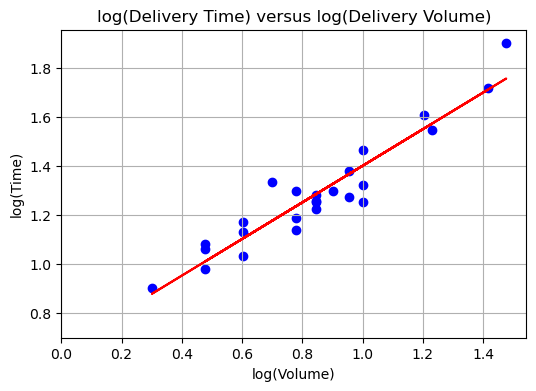

In [11]:
plt.close()
plt.xlim(np.log10([1,35]))
plt.ylim(np.log10([5,90]))
plt.scatter(data.Volumelog, data.Timelog, color='blue')
plt.grid()            
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.title('log(Delivery Time) versus log(Delivery Volume)')
plt.xlabel('log(Volume)')
plt.ylabel('log(Time)')
#   add best model
plt.plot(data.Volumelog, mod1.predict(), color='red')
plt.show()

residual analysis

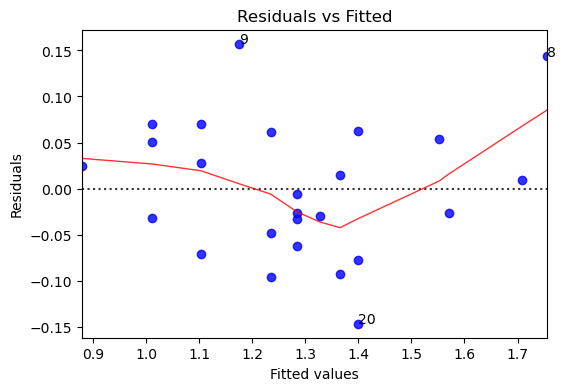

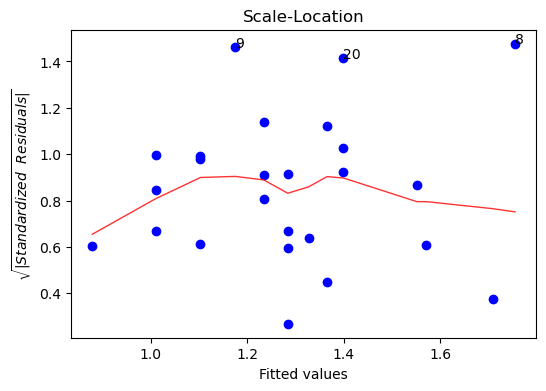

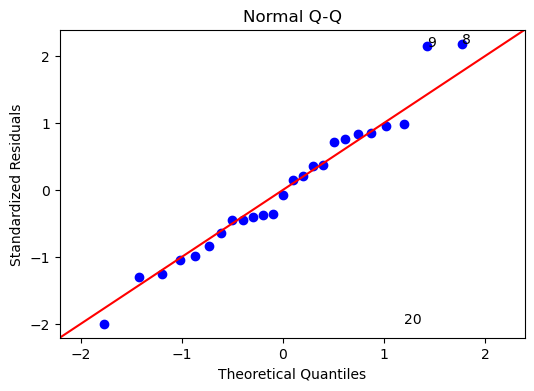

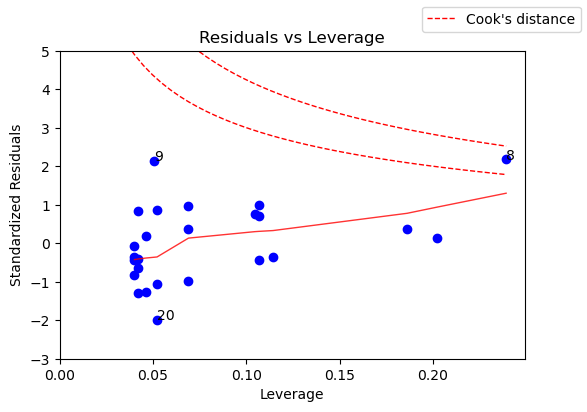

In [12]:
diagnostic_plots(X=data.Volumelog, y=data.Timelog, model_fit=mod1)

REMARKS:
1.  Tukey-Anscombe plot shows strange behaviour on the right side.
    In the simulation it is visible that the original curve is extreme.\
    => The expected value of the residuals cannot be constant.
2.  Scale-location plot is okay.\
    => There is no hint that the scattering of the residuals is not constant.
3.  q-q plot is okay.\
    => There is no hint that the residuals are not normally distributed.

CONCLUSION: The fit is satisfactory. But let us try als the square-root transformation.

# 2. Variant

In [13]:
mod2 = smf.ols(formula='Timelog ~ Volumesq', data=data).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Timelog   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     247.8
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           8.27e-14
Time:                        14:48:20   Log-Likelihood:                 32.783
No. Observations:                  25   AIC:                            -61.57
Df Residuals:                      23   BIC:                            -59.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6752      0.041     16.495      0.000       0.590       0.760
Volumesq       0.2177      0.014     15.743      0.000       0.189       0.246
==============================================================================
Omnibus:                        1.745   Durbin-Watson:                   1.361
Prob(Omnibus):                  0.418   Jarque-Bera (JB):                1.072
Skew:                           0.507   Prob(JB):                        0.585
Kurtosis:                       2.994   Cond. No.                         9.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

scatter diagram: log(Time) versus sqrt(Volume)

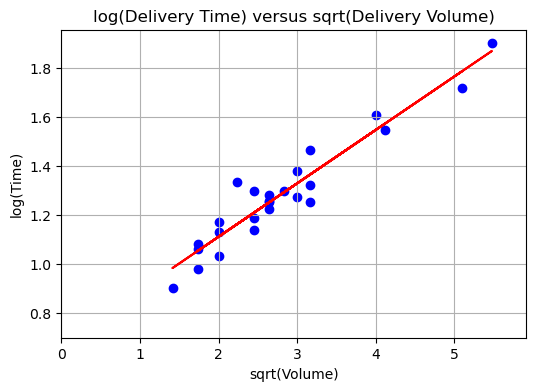

In [14]:
plt.close()
plt.xlim(np.sqrt([0,35]))
plt.ylim(np.log10([5,90]))
plt.scatter(data.Volumesq, data.Timelog, color='blue')
plt.grid()            
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.title('log(Delivery Time) versus sqrt(Delivery Volume)')
plt.xlabel('sqrt(Volume)')
plt.ylabel('log(Time)')
#   add best model
plt.plot(data.Volumesq, mod2.predict(), color='red')
plt.show()

residual analysis

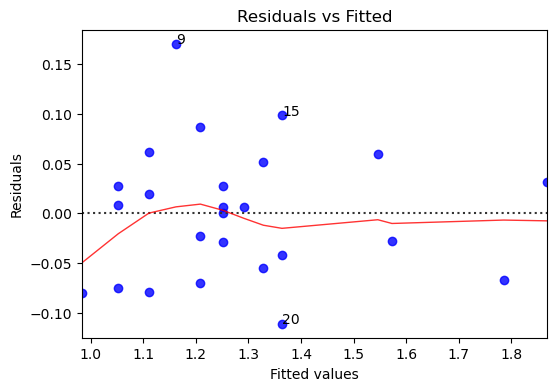

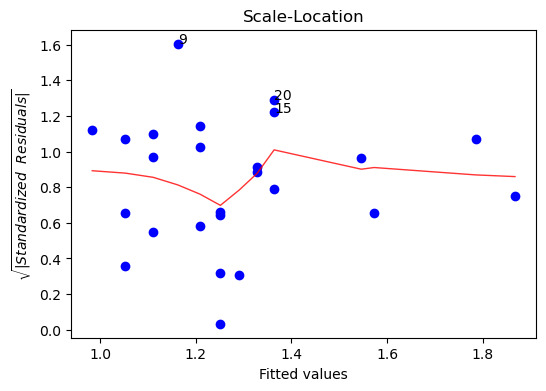

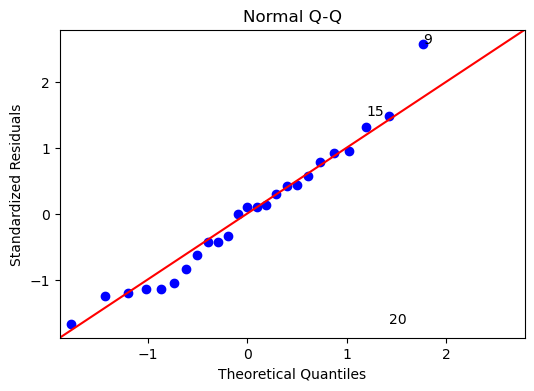

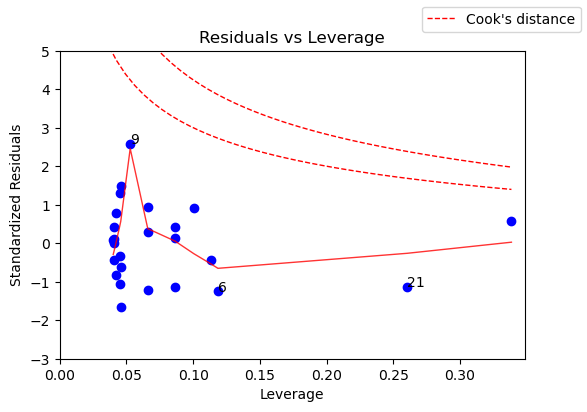

In [15]:
diagnostic_plots(X=data.Volumesq, y=data.Timelog, model_fit=mod2)

REMARKS:
1.  Tukey-Anscombe plot is okay.\
    => The expected value of the residuals is constant.
2.  Scale-location plot is okay.\
    => The scattering of the residuals is constant.
3.  q-q plot is okay.\
    => Residuals are normally distributed.

CONCLUSION: The fit is perfect.

# Correlation of the Residuals

WARNING: We absolutely have NO idea if the chronological order in the data set "vending-machines.dat" has never been changed.
         At least there is no obvious order visible in the data set, except the ordering with respect to the Town.
          => We will look at the correlation of the residuals assuming that in the data set "vending-machines.dat" we still have the original order.

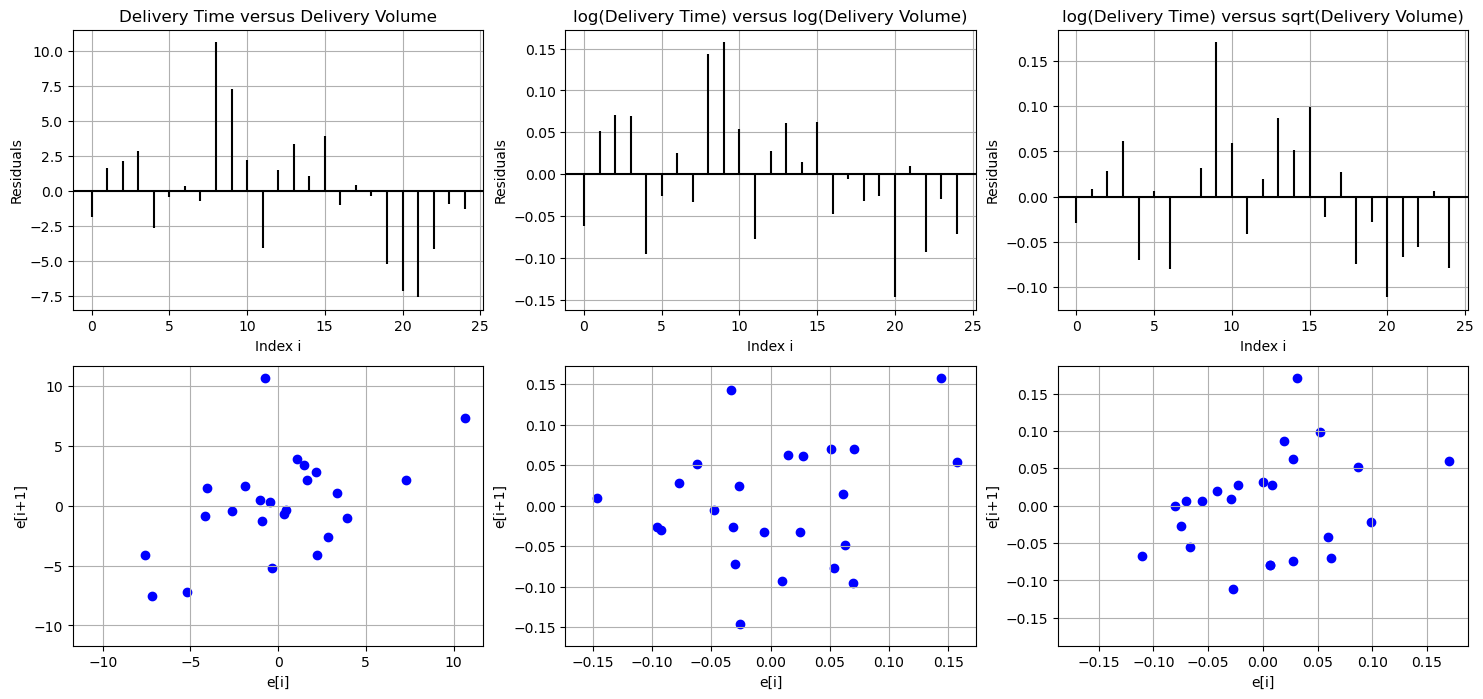

In [16]:
plt.close()
plt.rcParams['figure.figsize'] = [18, 8]
fig, axs = plt.subplots(2, 3)
ts0 = mod.resid                                                                                                     
max0 = 1.1*np.max(np.abs(ts0))                                                                                      
axs[0,0].grid()                                                                                                     
axs[0,0].vlines(x=range(len(ts0)), ymin=0, ymax=ts0, color='black')                                                   
axs[0,0].axhline(y=0, color='black')                                                                                
axs[0,0].set_title('Delivery Time versus Delivery Volume')                                                          
axs[0,0].set_xlabel('Index i')                                                                                      
axs[0,0].set_ylabel('Residuals')                                                                                    
#   correlation:  e[t+1] ~ e[t]                                                                                     
axs[1,0].grid()                                                                                                     
axs[1,0].scatter(ts0[0:(len(ts0)-1)], ts0[1:len(ts0)], color='blue')                  
axs[1,0].set_xlim([-max0,max0])                                                                                     
axs[1,0].set_ylim([-max0,max0])                                                                                     
axs[1,0].set_xlabel('e[i]')                                                                                         
axs[1,0].set_ylabel('e[i+1]')                                                                                       
                                                                                                                    
ts1 = mod1.resid                                                                                                    
max1 = 1.1*np.max(np.abs(ts1))                                                                                      
axs[0,1].grid()                                                                                                     
axs[0,1].vlines(x=range(len(ts1)), ymin=0, ymax=ts1, color='black')                                                   
axs[0,1].axhline(y=0, color='black')                                                                                
axs[0,1].set_title('log(Delivery Time) versus log(Delivery Volume)')                                                
axs[0,1].set_xlabel('Index i')                                                                                      
axs[0,1].set_ylabel('Residuals')                                                                                    
#   correlation:  e[t+1] ~ e[t]                                                                                     
axs[1,1].grid()                                                                                                     
axs[1,1].scatter(ts1[0:(len(ts1)-1)], ts1[1:len(ts1)], color='blue')                    
axs[1,1].set_xlim([-max1,max1])                                                                                     
axs[1,1].set_ylim([-max1,max1])                                                                                     
axs[1,1].set_xlabel('e[i]')                                                                                         
axs[1,1].set_ylabel('e[i+1]')                                                                                       
                                                                                                                    
ts2 = mod2.resid                                                                                                    
max2 = 1.1*np.max(np.abs(ts2))                                                                                      
axs[0,2].grid()                                                                                                     
axs[0,2].vlines(x=range(len(ts0)), ymin=0, ymax=ts2, color='black')                                                   
axs[0,2].axhline(y=0, color='black')                                                                                
axs[0,2].set_title('log(Delivery Time) versus sqrt(Delivery Volume)')                                               
axs[0,2].set_xlabel('Index i')                                                                                      
axs[0,2].set_ylabel('Residuals')                                                                                    
#   correlation:  e[t+1] ~ e[t]                                                                                     
axs[1,2].grid()                                                                                                     
axs[1,2].scatter(ts2[0:(len(ts2)-1)], ts2[1:len(ts2)], color='blue')                    
axs[1,2].set_xlim([-max2,max2])                                                                                     
axs[1,2].set_ylim([-max2,max2])                                                                                     
axs[1,2].set_xlabel('e[i]')                                                                                         
axs[1,2].set_ylabel('e[i+1]')   
plt.rcParams['figure.figsize'] = [6, 4]

REMARKS:
- Model 0 and 2 have slightly positiv correlated residuals.
- Model 1 on the other hand has uncorrelated residuals. 
- Since the order in the data set might not correspond anymore to the original order we safely ignore these findings.